In [1]:
%matplotlib inline
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os
import pandas as pd
import re
from tqdm import tqdm
from multiprocessing import Pool
from spellchecker import SpellChecker
import string
import math

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from nltk import word_tokenize

# For encoding labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

Using TensorFlow backend.


### Viz function selection

In [46]:
df_grid_search_history_broad_cat=pd.read_csv('../../output/grid_search_history_broad_cat.tsv', sep='\t').sort_values('val_acc', ascending=False)

In [48]:
df_grid_search_history_broad_cat.sample(3)

Unnamed: 0       acc   val_acc  val_acc_real      loss  val_loss  \
555          555  0.762768  0.734583           NaN  0.761871  0.842163   
4936        4936  0.173631  0.170655           NaN  8.650764  8.679786   
4133        4133  0.013601  0.014286           NaN  8.316889  8.213513   

      epochs  conv_num_filters  conv_kernel_size conv_act  out_act time_stamp  
555        6                32                 3     tanh  softmax        NaN  
4936      37               128                 3  sigmoid     tanh        NaN  
4133      34                64                 7  sigmoid     tanh        NaN

In [26]:
df_grid_search_history_broad_cat['conv_out_act']=df_grid_search_history_broad_cat.conv_act+'_'+df_grid_search_history_broad_cat.out_act

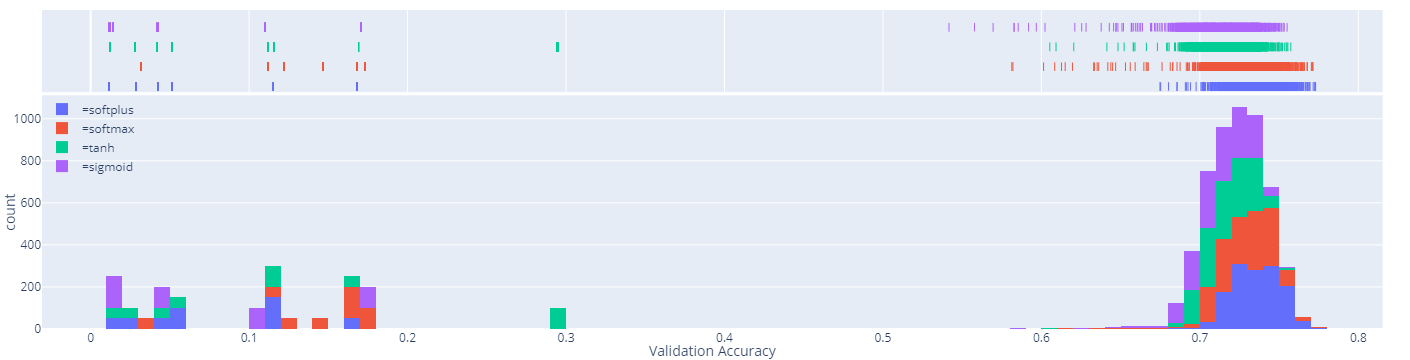

In [84]:
import plotly.express as px
fig = px.histogram(df_grid_search_history_broad_cat, x="val_acc", color="conv_act", marginal="rug", # can be `box`, `violin`
                         hover_data=df_grid_search_history_broad_cat.columns, nbins=150,
                   labels=dict(conv_act='', val_acc='Validation Accuracy', count='Count')
                  )
fig.update_layout(width=800, height=350)
fig.update_layout(
    legend=dict(x=0, y=0.6, orientation='v', bgcolor='rgba(0,0,0,0)'),
    margin={'t': 10, 'b': 10, 'r':0, 'l':20},
)
# fig.update_yaxes(title_text='Count')
fig.write_image('../../output/fig/grid_search_history_broad_cat.pdf')
fig.show()

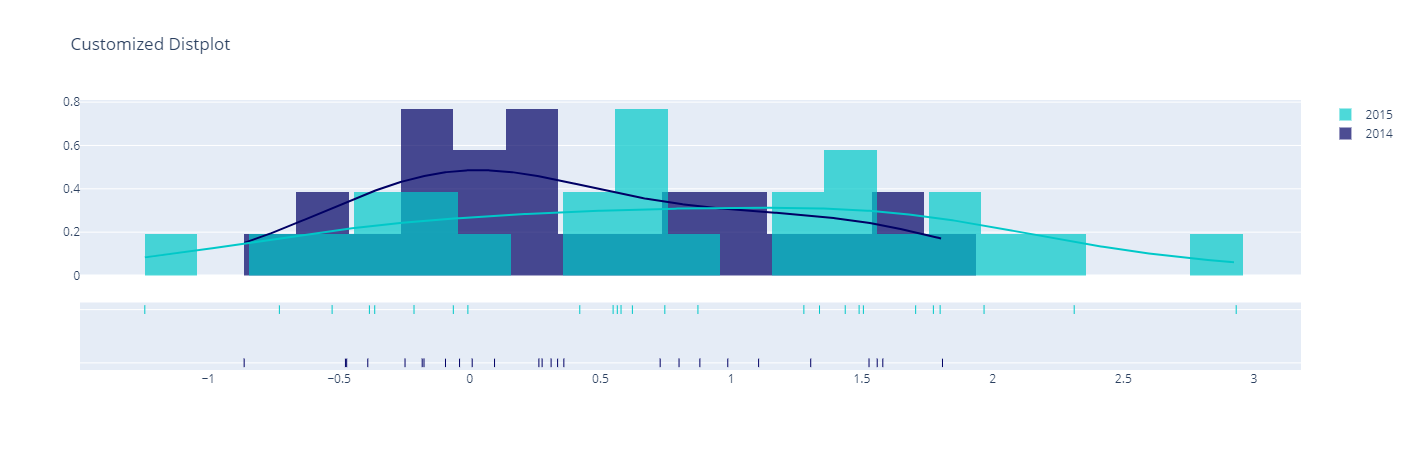

In [90]:
import plotly.figure_factory as ff
import numpy as np

x1 = np.random.randn(26)
x2 = np.random.randn(26) + .5

group_labels = ['2014', '2015']

rug_text_one = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                'u', 'v', 'w', 'x', 'y', 'z']

rug_text_two = ['aa', 'bb', 'cc', 'dd', 'ee', 'ff', 'gg', 'hh', 'ii', 'jj',
                'kk', 'll', 'mm', 'nn', 'oo', 'pp', 'qq', 'rr', 'ss', 'tt',
                'uu', 'vv', 'ww', 'xx', 'yy', 'zz']

rug_text = [rug_text_one, rug_text_two] # for hover in rug plot
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

# Create distplot with custom bin_size
fig = ff.create_distplot(
    [x1, x2], group_labels, bin_size=.2,
    rug_text=rug_text, colors=colors)

fig.update_layout(title_text='Customized Distplot')
fig.show()

### Missing data analysis

In [2]:
train_file_path='../../dataset/UCF/train/'
file_list=os.listdir(train_file_path)
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, pd.read_pickle(train_file_path+file, compression='gzip')])

test_file_path='../../dataset/UCF/test/'
file_list=os.listdir(test_file_path)
df_test=pd.DataFrame()
for file in file_list:
    df_test=pd.concat([df_test, pd.read_pickle(test_file_path+file, compression='gzip')])
    
len(df_train), len(df_test)

(154424, 38607)

In [26]:
df_train.columns

Index(['DLN', 'EIN', 'FILING_TYPE', 'IRS990EZ_p3_DscrptnPrgrmSrvcAccmTxt',
       'IRS990EZ_p3_PrmryExmptPrpsTxt', 'IRS990PF_p16b_RltnshpSttmntTxt',
       'IRS990PF_p9a_DscrptnTxt', 'IRS990ScheduleO_ExplntnTxt',
       'IRS990_p1_ActvtyOrMssnDsc', 'IRS990_p3_DscS', 'IRS990_p3_MssnDsc',
       'OBJECT_ID', 'RETURN_ID', 'RETURN_TYPE', 'SUB_DATE', 'TAXPAYER_NAME',
       'TAX_PERIOD', 'YEAR', '95_and_before', 'NTEE1', 'mission', 'prgrm_dsc',
       'mission_spellchk', 'prgrm_dsc_spellchk'],
      dtype='object')

In [27]:
len(df_train[df_train.mission_spellchk.isna()]), len(df_train[df_train.mission_spellchk.isna()]), len(df_train[df_train.mission_spellchk=='']), len(df_train[df_train.mission_spellchk==''])

(0, 0, 0, 0)

In [28]:
len(df_test[df_test.mission_spellchk.isna()]), len(df_test[df_test.mission_spellchk.isna()]), len(df_test[df_test.mission_spellchk=='']), len(df_test[df_test.mission_spellchk==''])

(0, 0, 0, 0)

In [24]:
len(df_train[df_train.prgrm_dsc_spellchk.isna()]), len(df_train[df_train.prgrm_dsc_spellchk.isna()]), len(df_train[df_train.prgrm_dsc_spellchk=='']), len(df_train[df_train.prgrm_dsc_spellchk==''])

(0, 0, 0, 0)

In [25]:
len(df_test[df_test.prgrm_dsc_spellchk.isna()]), len(df_test[df_test.prgrm_dsc_spellchk.isna()]), len(df_test[df_test.prgrm_dsc_spellchk=='']), len(df_test[df_test.prgrm_dsc_spellchk==''])

(0, 0, 0, 0)

In [ ]:
# Export to Excel. 
df_train.to_excel('../../output/df_train.xlsx')
df_test.to_excel('../../output/df_test.xlsx')